# Image Classification of ATLAS Calorimeter Topo-Clusters

This notebook includes performance comparisons of different Machine Learning techniques for classifying topological clusters in the ATLAS calorimeter. 

### The task

Train a classifier to determine which type of particle generated the parton showers in the cluster (e.g. $e^{\pm}$ vs. $\pi^{\pm}$ or $\pi^0$ vs. $\pi^{\pm}$).

### The cluster images

Each cluster is associated with six 2D images, corresponding to the barrels layers of the EM (EMB1, EMB2, EMB3) and HAD (TileBar0, TileBar2, TileBar3) calorimeters. Normalized (per layer)( calorimeter cell energies are used as pixel values. The image size is $0.4\times0.4$ in $\eta\times\phi$ space.

The following models are implemented:

1. Simple fully-connected Neural Network (flattening the images, developing a separate NN per calo layer).
2. Simple combinations (via a new NN, or combined single deep NN) of the flattened NNs from above.
3. Convolutional Neural Networks using only one layer (preserving the shape of the 2D images).
4. A network with multiple images as inputs, and one output (first couple of ConvNets are trained separately, then flattened and concatenated). 

TODO
- Cleanup code a bit, in particular make it easier to swap samples.
- Probably modify inputs to be just numpy arrays (rather than a dictionary of arrays), makes it easier to slice and dice inputs. 
- Implement a network of concatenated ConvNets taking all calorimeter layer images into account.
- Also compare the performance with other ML algorithms; logistic regression, SVD, Naive Bias, Gaussians, etc.


In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plotpath = '/g/g16/heinz6/workspace/caloml-atlas/code/caloml-atlas-py/classifier/Plots'
modelpath = '/g/g16/heinz6/workspace/caloml-atlas/code/caloml-atlas-py/classifier/Models'
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [2]:
import tensorflow as tf

# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2","/gpu:3"])
# # strategy = tf.distribute.MirroredStrategy()
# ngpu = strategy.num_replicas_in_sync
# print ('Number of devices: {}'.format(ngpu))

## Import the datasets 

The notebook is structured to make the swapping of datasets trivial. 

In [3]:
# import pi+- vs. pi0 images

# seed = 10
# np.random.seed(seed)
path = '/usr/WS1/hip/ML4Jets/regression_images/images_v6_v01-17-g2679fe7/'
#path = '/eos/user/m/mswiatlo/images/'

# TODO fix input files so that it is easier to split up the events
p0 = np.load(path+"pi0.npz")
pp = np.load(path+"piplus.npz")
pm = np.load(path+"piminus.npz")

#clean up to round numbers, which are prefered by tf.keras
#don't actually need this
# p0d = {}
# p0d = {key:p0[key][:180000] for key in p0}
# # p0=p0d

# ppd = {}
# ppd = {key:pp[key][:180000] for key in pp}
# # pp=ppd

# pmd = {}
# pmd = {key:pm[key][:280000] for key in pm}
# pm=pmd

# pc = {}
#concat pp and pm for/ greater stats
# pc = {key:np.append(pp[key], pm[key], 0) for key in pp}
# pp = pc # naughty, just replace it so we don't have to change code later

np0 = len(p0['EMB1'])
npp = len(pp['EMB1'])
npm = len(pm['EMB1'])
# npc = len(pc['EMB1'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
# print("Number of cpi events: {}".format(npc))
print("Total: {}".format(np0+npp+npm))

# print pp['label']
# print pm['label']
# print p0['label']

Number of pi0 events: 211196
Number of pi+ events: 357524
Number of pi- events: 434626
Total: 1003346


In [4]:
list(p0.keys())

['TileBar2',
 'EMB3',
 'cluster_ENG_CALIB_TOT',
 'cluster_sumCellE',
 'TileBar1',
 'TileBar0',
 'cluster_nCells',
 'clusterPt',
 'clusterIndex',
 'label',
 'clusterEta',
 'EMB1',
 'clusterPhi',
 'EMB2',
 'clusterE',
 'truthE']

In [13]:
num_check = 20
b = np.zeros(num_check)
for idx in np.arange(num_check):
    a = 0
    a += sum(sum(p0['EMB1'][idx]))
    a += sum(sum(p0['EMB2'][idx]))
    a += sum(sum(p0['EMB3'][idx]))
    a += sum(sum(p0['TileBar0'][idx]))
    a += sum(sum(p0['TileBar1'][idx]))
    a += sum(sum(p0['TileBar2'][idx]))
    b[idx] = 0
    
print(b)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
def flag_empty_images(cluster_data):
    emb1 = cluster_data['EMB1']
    emb2 = cluster_data['EMB2']
    emb3 = cluster_data['EMB3']
    tile0 = cluster_data['TileBar0']
    tile1 = cluster_data['TileBar1']
    tile2 = cluster_data['TileBar2']

    layers = ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2']
    y_est = 0

    print('Finding blank images...')
    for l in layers:
        num_inst = cluster_data[l].shape[0]
        curr_sum = np.sum(cluster_data[l].reshape(num_inst,-1), -1)
        y_est = y_est + curr_sum

    num_clusters = len(y_est)
    num_blanks_1 = sum(y_est==0)

    print('Flagging blank images...')
    flag = np.where(y_est==0, 1, 0)
    num_blanks_2 = sum(flag==1)

    if num_blanks_1 != num_blanks_2:
        print('Error: number of blanks do not match.')
        sys.exit()

    print('\nImages:\nTotal: {}\nEmpty: {}\nBlank percentage: {:.2f}%'.format(\
        num_clusters, num_blanks_2, 100*num_blanks_2/num_clusters))

    return flag

In [12]:
flag = flag_empty_images(p0)

Finding blank images...
Flagging blank images...

Images:
Total: 211196
Empty: 422
Blank percentage: 0.20%


### Plot a few example images

<Figure size 432x288 with 0 Axes>

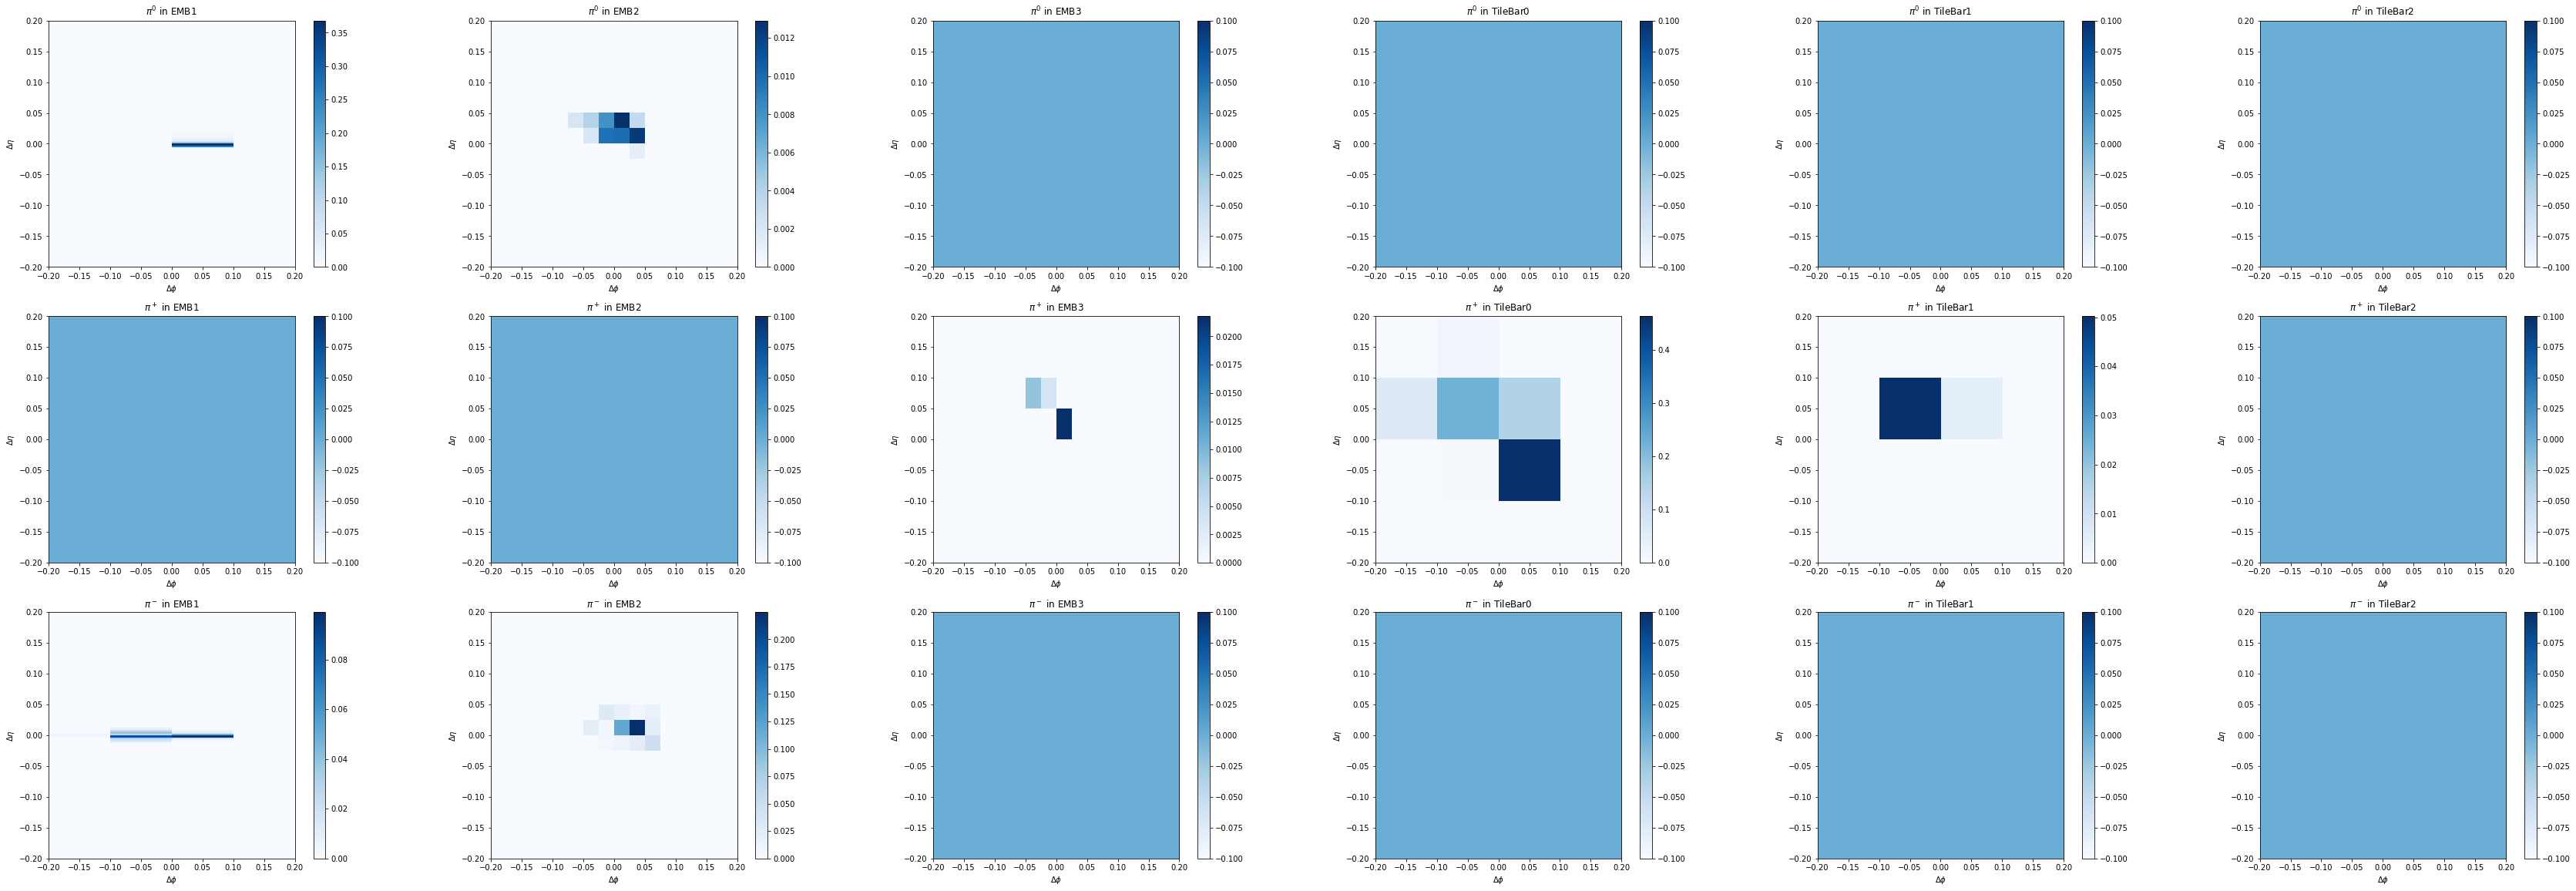

In [5]:
# plots for E = 0.5-2000 GeV pi0/pi+/pi- samples

from matplotlib.colors import Normalize, LogNorm

# specify which cluster to plot
cluster = 90

# make the plot
plt.cla(); plt.clf()
fig = plt.figure(figsize=(60,20))
fig.patch.set_facecolor('white')

i = 1
for layer in layers:
    
    # pi0
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(p0[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^0$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

for layer in layers:
    # pi+
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(pp[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^+$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

for layer in layers:
    # pi-
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(pm[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^-$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

# show the plots
plt.savefig(plotpath+'/plots_pi0_plus_minus.pdf')
plt.show()


### Plot a few histograms

NameError: name 'pion' is not defined

<Figure size 432x288 with 0 Axes>

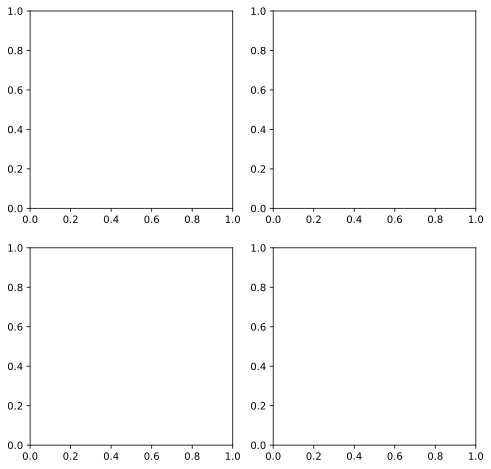

In [86]:
# histograms for pT = 100 GeV electron/pion samples

n_bins=30

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 2, figsize=(8,8))
fig.patch.set_facecolor('white')

# number of cells per cluster
ax[0,0].hist(pion['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='Pions')
ax[0,0].hist(elec['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='Electrons')
ax[0,0].set_xlabel('Cells/Cluster')
ax[0,0].legend()

# cluster energy
ax[0,1].hist(pion['clusterE'], bins=n_bins, normed=True, range=(50,150), alpha=0.7, label='Pions')
ax[0,1].hist(elec['clusterE'], bins=n_bins, normed=True, range=(50,150), alpha=0.7, label='Electrons')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(pion['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='Pions')
ax[1,0].hist(elec['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='Electrons')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(pion['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='Pions')
ax[1,1].hist(elec['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='Electrons')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

plt.show()
#plt.savefig('hist_pion_electron.pdf')

/collab/usr/gapps/python/build/spack-toss3.3/opt/spack/linux-rhel7-x86_64/gcc-4.9.3/python-3.7.2-asydydmavj2puklmx5t6cu3ruzmg2b3a/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


<Figure size 432x288 with 0 Axes>

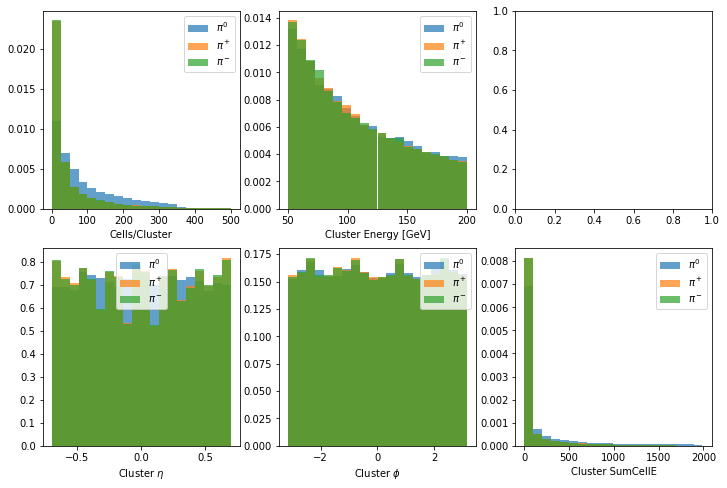

In [6]:
# histograms for E = 0.5-2000 GeV pi0/pi+/pi- samples

n_bins=20

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 3, figsize=(12,8))
fig.patch.set_facecolor('white')

# number of cells per cluster
ax[0,0].hist(p0['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^0$')
ax[0,0].hist(pp['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^+$')
ax[0,0].hist(pm['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^-$')
# ax[0,0].hist(pc['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^{\pm}$')
ax[0,0].set_xlabel('Cells/Cluster')
# ax[0,0].text(0.6,0.5,'ATLAS Internal',transform=ax[0,0].transAxes)
ax[0,0].legend()

# cluster energy
ax[0,1].hist(p0['clusterE'], bins=n_bins, normed=True, range=(50,200), alpha=0.7, label='$\pi^0$')
ax[0,1].hist(pp['clusterE'], bins=n_bins, normed=True, range=(50,200), alpha=0.7, label='$\pi^+$')
ax[0,1].hist(pm['clusterE'], bins=n_bins, normed=True, range=(50,200), alpha=0.7, label='$\pi^-$')
# ax[0,1].hist(pc['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^{\pm}$')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(p0['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,0].hist(pp['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,0].hist(pm['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,0].hist(pc['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(p0['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,1].hist(pp['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,1].hist(pm['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

# # cluster EM prob
# ax[0,2].hist(p0['cluster_EM_PROBABILITY'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
# ax[0,2].hist(pp['cluster_EM_PROBABILITY'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
# ax[0,2].hist(pm['cluster_EM_PROBABILITY'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# # ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
# ax[0,2].set_xlabel('Cluster EMProb')
# ax[0,2].legend()

# cluster sum cell e
ax[1,2].hist(p0['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,2].hist(pp['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,2].hist(pm['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,2].set_xlabel('Cluster SumCellE')
ax[1,2].legend()

plt.savefig(plotpath+'hist_pi0_plus_minus.pdf')
plt.show()


## 1. Simple feed-forward Neural Network

In [7]:
# # Train on E = 0.5-2000 GeV pi0/pi+/pi- samples

# here, define a function to flatten inputs
def format_flat(data_0, data_1, selected_layer, len_phi = len_phi, len_eta = len_eta):
    layer = layers[selected_layer]
    num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])

    X = np.append(data_0[layer].reshape((len(data_0[layer]),num_pixels)),
                  data_1[layer].reshape((len(data_1[layer]),num_pixels)), axis=0)

    y = np.append(data_0['label'], data_1['label'], axis=0)

    print (X.shape)
    print (y.shape)
    return X, y, num_pixels

In [8]:
x_flat = {}
y_flat = {}
num_pixels_flat = {}
for layer_i, layer_name in enumerate(layers):
    x_flat[layer_i], y_flat[layer_i], num_pixels_flat[layer_i] = format_flat(p0, pp, layer_i)

(568720, 512)
(568720, 1)
(568720, 256)
(568720, 1)
(568720, 128)
(568720, 1)
(568720, 16)
(568720, 1)
(568720, 16)
(568720, 1)
(568720, 8)
(568720, 1)


In [9]:
#split up data into separate training, validation, and testing

test_size = 24000
validation_size = 24000
from sklearn.model_selection import train_test_split
def make_split_samples(X, y, test_size, validation_size):
    X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
    X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

    # normalize inputs from 0-255 to 0-1
    # this seems to be done already??
#     X_tr = X_tr / 255
#     X_te = X_te / 255
#     X_vl = X_vl / 255

    # one hot encode outputs
    from tensorflow.keras import utils
    
    y_tr_onehot = utils.to_categorical(y_tr, 2)
    y_te_onehot = utils.to_categorical(y_te, 2)
    y_vl_onehot = utils.to_categorical(y_vl, 2)
    num_classes = y_te_onehot.shape[1]
    print("y_train.shape: ",y_tr.shape)
    print("y_train_onehot.shape: ",y_tr_onehot.shape)
    
    return X_tr, X_te, X_vl, y_tr_onehot, y_te_onehot, y_vl_onehot

In [10]:
x_flat_tr = {}
x_flat_te = {}
x_flat_vl = {}
y_flat_tr_onehot = {}
y_flat_te_onehot = {}
y_flat_vl_onehot = {}
for layer_i, layer_name in enumerate(layers):
    x_flat_tr[layer_i], x_flat_te[layer_i], x_flat_vl[layer_i], y_flat_tr_onehot[layer_i], y_flat_te_onehot[layer_i], y_flat_vl_onehot[layer_i] = make_split_samples(x_flat[layer_i], y_flat[layer_i], test_size, validation_size)

y_train.shape:  (520720, 1)
y_train_onehot.shape:  (520720, 2)
y_train.shape:  (520720, 1)
y_train_onehot.shape:  (520720, 2)
y_train.shape:  (520720, 1)
y_train_onehot.shape:  (520720, 2)
y_train.shape:  (520720, 1)
y_train_onehot.shape:  (520720, 2)
y_train.shape:  (520720, 1)
y_train_onehot.shape:  (520720, 2)
y_train.shape:  (520720, 1)
y_train_onehot.shape:  (520720, 2)


In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [12]:
# define baseline fully-connected NN model
def baseline_nn_model(number_pixels):
    # create model
    # with strategy.scope():    
    model = Sequential()
    used_pixels = number_pixels
#   if number_pixels < 128:
#       used_pixels = 128
    model.add(Dense(number_pixels, input_dim=number_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(used_pixels, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(int(used_pixels/2), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    optimizer = Adam(lr=5e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
    
    return model

In [25]:
# build the model
models_flat = {}
for layer_i, layer_name in enumerate(layers):
    models_flat[layer_i] = baseline_nn_model(num_pixels_flat[layer_i])
    models_flat[layer_i].summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 2)                

In [26]:
# now automated with functions
history_flat = {}
scores = {}
for layer_i, layer_name in enumerate(layers):
    print('On layer %s' % (layer_name))
    history_flat[layer_i] = models_flat[layer_i].fit(x_flat_tr[layer_i], y_flat_tr_onehot[layer_i], validation_data=(x_flat_vl[layer_i], y_flat_vl_onehot[layer_i]), epochs = 100, batch_size = 200, verbose = 2)
    scores[layer_i] = models_flat[layer_i].evaluate(x_flat_te[layer_i], y_flat_te_onehot[layer_i], verbose = 0)
    print('Finished layer %s' % (layer_name))

On layer EMB1
Epoch 1/100
2604/2604 - 17s - loss: 0.4250 - acc: 0.8099 - val_loss: 0.3793 - val_acc: 0.8350
Epoch 2/100
2604/2604 - 17s - loss: 0.3742 - acc: 0.8406 - val_loss: 0.3484 - val_acc: 0.8564
Epoch 3/100
2604/2604 - 17s - loss: 0.3420 - acc: 0.8611 - val_loss: 0.3166 - val_acc: 0.8738
Epoch 4/100
2604/2604 - 17s - loss: 0.3175 - acc: 0.8739 - val_loss: 0.3008 - val_acc: 0.8814
Epoch 5/100
2604/2604 - 17s - loss: 0.3009 - acc: 0.8820 - val_loss: 0.2867 - val_acc: 0.8878
Epoch 6/100
2604/2604 - 17s - loss: 0.2904 - acc: 0.8872 - val_loss: 0.2760 - val_acc: 0.8937
Epoch 7/100
2604/2604 - 17s - loss: 0.2818 - acc: 0.8912 - val_loss: 0.2697 - val_acc: 0.8966
Epoch 8/100
2604/2604 - 17s - loss: 0.2755 - acc: 0.8941 - val_loss: 0.2651 - val_acc: 0.9000
Epoch 9/100
2604/2604 - 17s - loss: 0.2704 - acc: 0.8964 - val_loss: 0.2598 - val_acc: 0.9010
Epoch 10/100
2604/2604 - 17s - loss: 0.2665 - acc: 0.8982 - val_loss: 0.2572 - val_acc: 0.9013
Epoch 11/100
2604/2604 - 17s - loss: 0.2633 -

Epoch 88/100
2604/2604 - 17s - loss: 0.2211 - acc: 0.9170 - val_loss: 0.2311 - val_acc: 0.9140
Epoch 89/100
2604/2604 - 17s - loss: 0.2208 - acc: 0.9169 - val_loss: 0.2319 - val_acc: 0.9128
Epoch 90/100
2604/2604 - 17s - loss: 0.2208 - acc: 0.9171 - val_loss: 0.2324 - val_acc: 0.9130
Epoch 91/100
2604/2604 - 17s - loss: 0.2204 - acc: 0.9174 - val_loss: 0.2316 - val_acc: 0.9125
Epoch 92/100
2604/2604 - 17s - loss: 0.2207 - acc: 0.9172 - val_loss: 0.2313 - val_acc: 0.9132
Epoch 93/100
2604/2604 - 17s - loss: 0.2197 - acc: 0.9173 - val_loss: 0.2330 - val_acc: 0.9131
Epoch 94/100
2604/2604 - 17s - loss: 0.2200 - acc: 0.9171 - val_loss: 0.2322 - val_acc: 0.9137
Epoch 95/100
2604/2604 - 17s - loss: 0.2196 - acc: 0.9175 - val_loss: 0.2325 - val_acc: 0.9127
Epoch 96/100
2604/2604 - 17s - loss: 0.2196 - acc: 0.9176 - val_loss: 0.2319 - val_acc: 0.9130
Epoch 97/100
2604/2604 - 17s - loss: 0.2194 - acc: 0.9174 - val_loss: 0.2333 - val_acc: 0.9122
Epoch 98/100
2604/2604 - 17s - loss: 0.2190 - acc:

Epoch 74/100
2604/2604 - 11s - loss: 0.2346 - acc: 0.9050 - val_loss: 0.2316 - val_acc: 0.9074
Epoch 75/100
2604/2604 - 11s - loss: 0.2343 - acc: 0.9051 - val_loss: 0.2302 - val_acc: 0.9090
Epoch 76/100
2604/2604 - 11s - loss: 0.2344 - acc: 0.9051 - val_loss: 0.2311 - val_acc: 0.9074
Epoch 77/100
2604/2604 - 11s - loss: 0.2338 - acc: 0.9054 - val_loss: 0.2299 - val_acc: 0.9083
Epoch 78/100
2604/2604 - 11s - loss: 0.2337 - acc: 0.9053 - val_loss: 0.2301 - val_acc: 0.9077
Epoch 79/100
2604/2604 - 10s - loss: 0.2334 - acc: 0.9055 - val_loss: 0.2303 - val_acc: 0.9085
Epoch 80/100
2604/2604 - 11s - loss: 0.2333 - acc: 0.9055 - val_loss: 0.2293 - val_acc: 0.9088
Epoch 81/100
2604/2604 - 11s - loss: 0.2330 - acc: 0.9056 - val_loss: 0.2296 - val_acc: 0.9089
Epoch 82/100
2604/2604 - 11s - loss: 0.2327 - acc: 0.9063 - val_loss: 0.2297 - val_acc: 0.9090
Epoch 83/100
2604/2604 - 11s - loss: 0.2329 - acc: 0.9059 - val_loss: 0.2294 - val_acc: 0.9089
Epoch 84/100
2604/2604 - 11s - loss: 0.2322 - acc:

Epoch 61/100
2604/2604 - 9s - loss: 0.4134 - acc: 0.8125 - val_loss: 0.4128 - val_acc: 0.8088
Epoch 62/100
2604/2604 - 9s - loss: 0.4132 - acc: 0.8126 - val_loss: 0.4108 - val_acc: 0.8118
Epoch 63/100
2604/2604 - 9s - loss: 0.4126 - acc: 0.8131 - val_loss: 0.4079 - val_acc: 0.8142
Epoch 64/100
2604/2604 - 9s - loss: 0.4123 - acc: 0.8130 - val_loss: 0.4103 - val_acc: 0.8114
Epoch 65/100
2604/2604 - 9s - loss: 0.4122 - acc: 0.8132 - val_loss: 0.4069 - val_acc: 0.8140
Epoch 66/100
2604/2604 - 9s - loss: 0.4119 - acc: 0.8131 - val_loss: 0.4083 - val_acc: 0.8138
Epoch 67/100
2604/2604 - 9s - loss: 0.4115 - acc: 0.8134 - val_loss: 0.4167 - val_acc: 0.8115
Epoch 68/100
2604/2604 - 9s - loss: 0.4116 - acc: 0.8129 - val_loss: 0.4066 - val_acc: 0.8143
Epoch 69/100
2604/2604 - 9s - loss: 0.4113 - acc: 0.8131 - val_loss: 0.4065 - val_acc: 0.8131
Epoch 70/100
2604/2604 - 9s - loss: 0.4110 - acc: 0.8132 - val_loss: 0.4094 - val_acc: 0.8151
Epoch 71/100
2604/2604 - 9s - loss: 0.4108 - acc: 0.8137 - v

Epoch 48/100
2604/2604 - 4s - loss: 0.5409 - acc: 0.6517 - val_loss: 0.5313 - val_acc: 0.6583
Epoch 49/100
2604/2604 - 4s - loss: 0.5410 - acc: 0.6514 - val_loss: 0.5312 - val_acc: 0.6583
Epoch 50/100
2604/2604 - 4s - loss: 0.5413 - acc: 0.6515 - val_loss: 0.5311 - val_acc: 0.6584
Epoch 51/100
2604/2604 - 4s - loss: 0.5407 - acc: 0.6519 - val_loss: 0.5311 - val_acc: 0.6585
Epoch 52/100
2604/2604 - 4s - loss: 0.5408 - acc: 0.6520 - val_loss: 0.5309 - val_acc: 0.6585
Epoch 53/100
2604/2604 - 4s - loss: 0.5409 - acc: 0.6512 - val_loss: 0.5308 - val_acc: 0.6585
Epoch 54/100
2604/2604 - 4s - loss: 0.5409 - acc: 0.6520 - val_loss: 0.5308 - val_acc: 0.6586
Epoch 55/100
2604/2604 - 4s - loss: 0.5408 - acc: 0.6517 - val_loss: 0.5311 - val_acc: 0.6585
Epoch 56/100
2604/2604 - 4s - loss: 0.5407 - acc: 0.6516 - val_loss: 0.5309 - val_acc: 0.6584
Epoch 57/100
2604/2604 - 4s - loss: 0.5408 - acc: 0.6521 - val_loss: 0.5308 - val_acc: 0.6586
Epoch 58/100
2604/2604 - 4s - loss: 0.5409 - acc: 0.6522 - v

Epoch 35/100
2604/2604 - 4s - loss: 0.5269 - acc: 0.6466 - val_loss: 0.5239 - val_acc: 0.6539
Epoch 36/100
2604/2604 - 4s - loss: 0.5268 - acc: 0.6465 - val_loss: 0.5237 - val_acc: 0.6539
Epoch 37/100
2604/2604 - 4s - loss: 0.5267 - acc: 0.6457 - val_loss: 0.5232 - val_acc: 0.6542
Epoch 38/100
2604/2604 - 4s - loss: 0.5265 - acc: 0.6465 - val_loss: 0.5230 - val_acc: 0.6546
Epoch 39/100
2604/2604 - 4s - loss: 0.5263 - acc: 0.6465 - val_loss: 0.5227 - val_acc: 0.6540
Epoch 40/100
2604/2604 - 4s - loss: 0.5262 - acc: 0.6470 - val_loss: 0.5226 - val_acc: 0.6539
Epoch 41/100
2604/2604 - 4s - loss: 0.5257 - acc: 0.6469 - val_loss: 0.5223 - val_acc: 0.6539
Epoch 42/100
2604/2604 - 4s - loss: 0.5256 - acc: 0.6466 - val_loss: 0.5220 - val_acc: 0.6540
Epoch 43/100
2604/2604 - 4s - loss: 0.5254 - acc: 0.6471 - val_loss: 0.5217 - val_acc: 0.6547
Epoch 44/100
2604/2604 - 4s - loss: 0.5253 - acc: 0.6468 - val_loss: 0.5216 - val_acc: 0.6543
Epoch 45/100
2604/2604 - 4s - loss: 0.5257 - acc: 0.6470 - v

Epoch 22/100
2604/2604 - 3s - loss: 0.6105 - acc: 0.6288 - val_loss: 0.6076 - val_acc: 0.6251
Epoch 23/100
2604/2604 - 4s - loss: 0.6108 - acc: 0.6288 - val_loss: 0.6071 - val_acc: 0.6251
Epoch 24/100
2604/2604 - 4s - loss: 0.6100 - acc: 0.6288 - val_loss: 0.6067 - val_acc: 0.6251
Epoch 25/100
2604/2604 - 3s - loss: 0.6098 - acc: 0.6288 - val_loss: 0.6063 - val_acc: 0.6251
Epoch 26/100
2604/2604 - 4s - loss: 0.6093 - acc: 0.6288 - val_loss: 0.6058 - val_acc: 0.6251
Epoch 27/100
2604/2604 - 4s - loss: 0.6085 - acc: 0.6288 - val_loss: 0.6053 - val_acc: 0.6251
Epoch 28/100
2604/2604 - 4s - loss: 0.6079 - acc: 0.6288 - val_loss: 0.6052 - val_acc: 0.6251
Epoch 29/100
2604/2604 - 4s - loss: 0.6075 - acc: 0.6288 - val_loss: 0.6045 - val_acc: 0.6251
Epoch 30/100
2604/2604 - 4s - loss: 0.6072 - acc: 0.6288 - val_loss: 0.6040 - val_acc: 0.6251
Epoch 31/100
2604/2604 - 3s - loss: 0.6064 - acc: 0.6288 - val_loss: 0.6036 - val_acc: 0.6251
Epoch 32/100
2604/2604 - 3s - loss: 0.6058 - acc: 0.6288 - v

In [27]:
for layer_i, layer_name in enumerate(layers):
    print('Saving {}'.format(layer_name))
    models_flat[layer_i].save(modelpath+'model_{}_flat_do20.h5'.format(layer_name))

Saving EMB1
Saving EMB2
Saving EMB3
Saving TileBar0
Saving TileBar1
Saving TileBar2


In [28]:
#alternate to fitting the model: load a saved model
models_flat = {}
for layer_i, layer_name in enumerate(layers):
    print('Loading {}'.format(layer_name))
    models_flat[layer_i] = tf.keras.models.load_model(modelpath+'model_{}_flat_do20.h5'.format(layer_name))

Loading EMB1
Loading EMB2
Loading EMB3
Loading TileBar0
Loading TileBar1
Loading TileBar2


<Figure size 432x288 with 0 Axes>

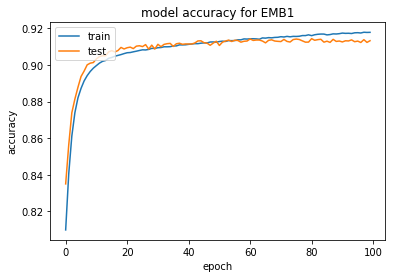

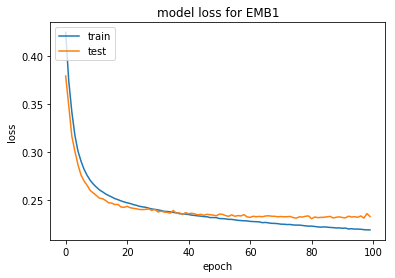

<Figure size 432x288 with 0 Axes>

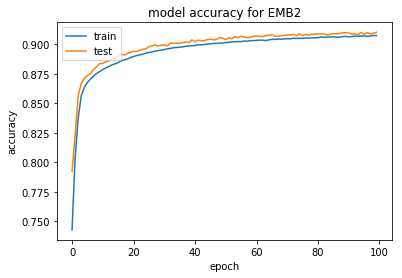

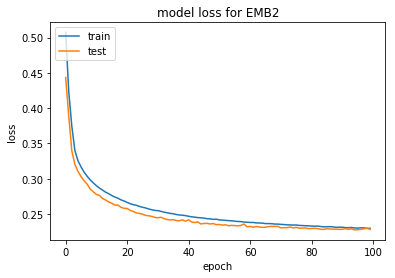

<Figure size 432x288 with 0 Axes>

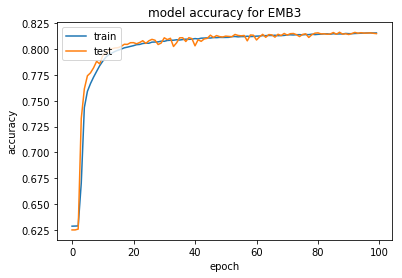

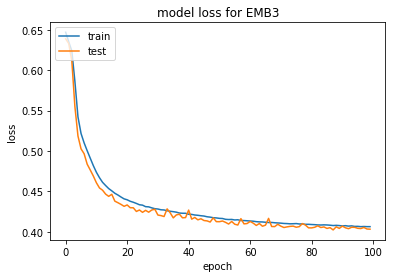

<Figure size 432x288 with 0 Axes>

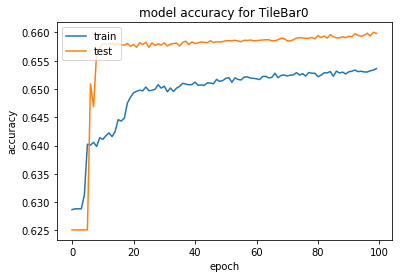

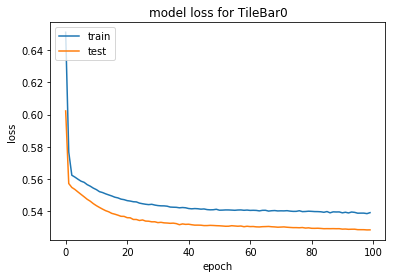

<Figure size 432x288 with 0 Axes>

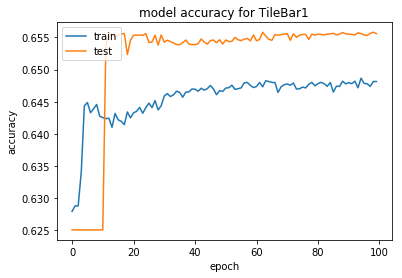

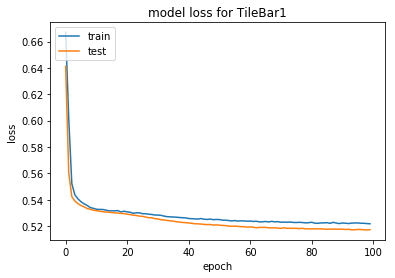

<Figure size 432x288 with 0 Axes>

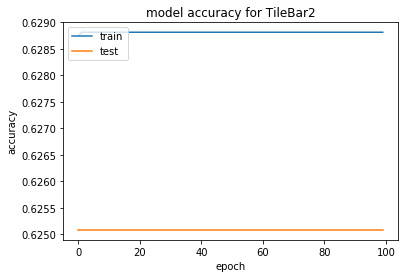

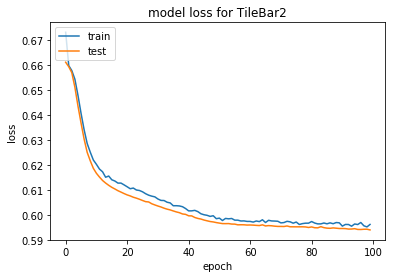

In [29]:
for layer_i, layer_name in enumerate(layers):
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_flat[layer_i].history['acc'])
    plt.plot(history_flat[layer_i].history['val_acc'])
    plt.title('model accuracy for {}'.format(layer_name))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/accuracy_{}.pdf'.format(layer_name))
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_flat[layer_i].history['loss'])
    plt.plot(history_flat[layer_i].history['val_loss'])
    plt.title('model loss for {}'.format(layer_name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/loss_{}.pdf'.format(layer_name))
    plt.show()

In [30]:
from sklearn.metrics import roc_curve, auc

In [31]:
# roc curves, for all layers


y_flat_pred = {}
fpr_flat_nn = {} 
tpr_flat_nn = {} 
thres_flat_nn = {}
auc_flat_nn = {}
for layer_i, layer_name in enumerate(layers):
    y_flat_pred[layer_i] = models_flat[layer_i].predict(x_flat_te[layer_i])
    fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], thres_flat_nn[layer_i] = roc_curve(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1],drop_intermediate=False)
    auc_flat_nn[layer_i] = auc(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i])
    print("Area under curve: {}".format(auc_flat_nn[layer_i]))

Area under curve: 0.95784646026229
Area under curve: 0.9638640822216822
Area under curve: 0.8635280875190149
Area under curve: 0.725218092056771
Area under curve: 0.7190320172973825
Area under curve: 0.6398166307915643


In [32]:
x_lc = np.append(1-p0['cluster_EM_PROBABILITY'],1 - pp['cluster_EM_PROBABILITY'])
y_lc = np.append(p0['label'], pp['label']) 

KeyError: 'cluster_EM_PROBABILITY is not a file in the archive'

In [33]:
fpr_lc, tpr_lc, thresh_lc = roc_curve(y_lc, x_lc)
auc_lc = auc(fpr_lc, tpr_lc)
print("Area under curve: {}".format(auc_lc))

NameError: name 'y_lc' is not defined

NameError: name 'fpr_lc' is not defined

<Figure size 432x288 with 0 Axes>

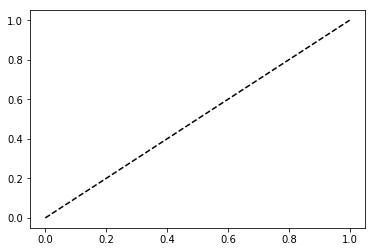

In [34]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_lc_only.pdf')
plt.show()

NameError: name 'fpr_lc' is not defined

<Figure size 432x288 with 0 Axes>

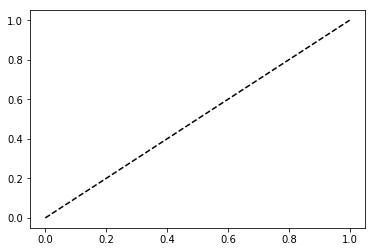

In [35]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_flat_nn[0], tpr_flat_nn[0], label='{} (area = {:.3f})'.format('EMB1', auc_flat_nn[0]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_lc_emb1_only.pdf')
plt.show()

NameError: name 'fpr_lc' is not defined

<Figure size 432x288 with 0 Axes>

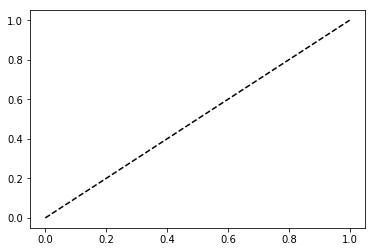

In [36]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_layers.pdf')
plt.show()


# Zoom in view of the upper left corner.
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_layers.pdf')
plt.show()


In [37]:
y_flat_pred_stack = np.column_stack((y_flat_pred[0][:,1], y_flat_pred[1][:,1],y_flat_pred[2][:,1],y_flat_pred[3][:,1],y_flat_pred[4][:,1],y_flat_pred[5][:,1]))

y_flat_pred_vl = {}
for layer_i, layer_name in enumerate(layers):
    y_flat_pred_vl[layer_i] = models_flat[layer_i].predict(x_flat_vl[layer_i])
#     print len(y_flat_pred_vl[layer_i])

y_flat_pred_vl_stack = np.column_stack((y_flat_pred_vl[0][:,1], y_flat_pred_vl[1][:,1],y_flat_pred_vl[2][:,1],y_flat_pred_vl[3][:,1],y_flat_pred_vl[4][:,1],y_flat_pred_vl[5][:,1]))

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

model_simpleCombine = Sequential()
model_simpleCombine.add(Dense(6, input_dim=6, kernel_initializer='normal', activation='relu'))
model_simpleCombine.add(Dense(4, activation='relu'))
model_simpleCombine.add(Dense(2, kernel_initializer='normal', activation='softmax'))
model_simpleCombine.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])
history_simpleCombine = model_simpleCombine.fit(y_flat_pred_stack, y_flat_te_onehot[0], epochs = 100, batch_size = 200, verbose = 2)

Epoch 1/100
120/120 - 0s - loss: 0.6551 - acc: 0.6285
Epoch 2/100
120/120 - 0s - loss: 0.5606 - acc: 0.6285
Epoch 3/100
120/120 - 0s - loss: 0.3897 - acc: 0.8233
Epoch 4/100
120/120 - 0s - loss: 0.2547 - acc: 0.9237
Epoch 5/100
120/120 - 0s - loss: 0.2108 - acc: 0.9303
Epoch 6/100
120/120 - 0s - loss: 0.1995 - acc: 0.9311
Epoch 7/100
120/120 - 0s - loss: 0.1959 - acc: 0.9317
Epoch 8/100
120/120 - 0s - loss: 0.1942 - acc: 0.9314
Epoch 9/100
120/120 - 0s - loss: 0.1932 - acc: 0.9321
Epoch 10/100
120/120 - 0s - loss: 0.1923 - acc: 0.9326
Epoch 11/100
120/120 - 0s - loss: 0.1920 - acc: 0.9319
Epoch 12/100
120/120 - 0s - loss: 0.1916 - acc: 0.9321
Epoch 13/100
120/120 - 0s - loss: 0.1913 - acc: 0.9320
Epoch 14/100
120/120 - 0s - loss: 0.1912 - acc: 0.9323
Epoch 15/100
120/120 - 0s - loss: 0.1909 - acc: 0.9315
Epoch 16/100
120/120 - 0s - loss: 0.1908 - acc: 0.9324
Epoch 17/100
120/120 - 0s - loss: 0.1906 - acc: 0.9322
Epoch 18/100
120/120 - 0s - loss: 0.1907 - acc: 0.9319
Epoch 19/100
120/12

<Figure size 432x288 with 0 Axes>

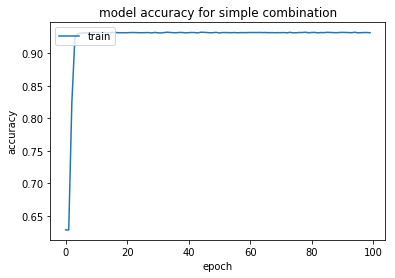

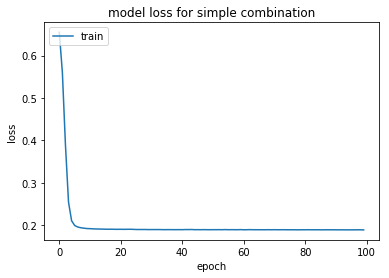

In [40]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_simpleCombine.history['acc'])
#     plt.plot(history_simpleCombine.history['val_acc'])
    plt.title('model accuracy for simple combination')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(plotpath+'accuracy_simpleCombine.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_simpleCombine.history['loss'])
#     plt.plot(history_simpleCombine.history['val_loss'])
    plt.title('model loss for simple combination')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(plotpath+'loss_simpleCombine.pdf')
    plt.show()
    

In [41]:
combined_pred = model_simpleCombine.predict(y_flat_pred_vl_stack)
fpr_simpleCombine, tpr_simpleCombine, thres_simpleCombine = roc_curve(y_flat_vl_onehot[layer_i][:,1], combined_pred[:,1])
auc_combined  = auc(fpr_simpleCombine, tpr_simpleCombine)
print(auc_combined)

0.974772141961423


NameError: name 'fpr_lc' is not defined

<Figure size 432x288 with 0 Axes>

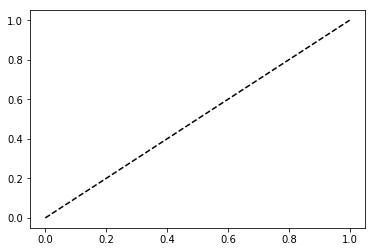

In [42]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers Combined", auc_combined))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig(plotpath+'roc_combine1_layers.pdf')
plt.show()


# Zoom in view of the upper left corner.
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers Combined", auc_combined))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(plotpath+'roc_zoom_combine1_layers.pdf')
plt.show()


In [43]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

In [44]:
with strategy.scope():    

    model_combine = Sequential()

    #EMB1
    input1 = Input(shape=(512,), name = 'input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dropout(0.2)(x1)
    x1 = Dense(256, activation='relu')(x1)
    x1 = Dropout(0.2)(x1)
    x1 = Dense(128, activation='relu')(x1)
    x1 = Dropout(0.2)(x1)

    #EMB2
    input2 = Input(shape=(256,), name = 'input2')
    x2 = Dense(256, activation='relu')(input2)
    x2 = Dropout(0.2)(x2)
    x2 = Dense(128, activation='relu')(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Dense(64, activation='relu')(x2)
    x2 = Dropout(0.2)(x2)

    #EMB3
    input3 = Input(shape=(128,), name = 'input3')
    x3 = Dense(128, activation='relu')(input3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(64, activation='relu')(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(32, activation='relu')(x3)
    x3 = Dropout(0.2)(x3)

    #Tile0
    input4 = Input(shape=(16,), name = 'input4')
    x4 = Dense(16, activation='relu')(input4)
    x4 = Dropout(0.2)(x4)
    x4 = Dense(8, activation='relu')(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Dense(4, activation='relu')(x4)
    x4 = Dropout(0.2)(x4)

    #Tile1
    input5 = Input(shape=(16,), name = 'input5')
    x5 = Dense(16, activation='relu')(input5)
    x5 = Dropout(0.2)(x5)
    x5 = Dense(8, activation='relu')(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Dense(4, activation='relu')(x5)
    x5 = Dropout(0.2)(x5)

    #Tile2
    input6 = Input(shape=(8,), name = 'input6')
    x6 = Dense(8, activation='relu')(input6)
    x6 = Dropout(0.2)(x6)
    x6 = Dense(4, activation='relu')(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Dense(2, activation='relu')(x6)
    x6 = Dropout(0.2)(x6)

    #Combination
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)

    output_combine = Dense(2, activation='softmax')(x)

    model_combine = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output_combine])
    model_combine.compile(loss='categorical_crossentropy', optimizer=Adam(lr=5e-5), metrics=['acc'])   

NameError: name 'strategy' is not defined

In [45]:
history_combine = model_combine.fit([x_flat_tr[0], x_flat_tr[1], x_flat_tr[2], x_flat_tr[3], x_flat_tr[4], x_flat_tr[5]], [y_flat_tr_onehot[0]], validation_data=([x_flat_vl[0], x_flat_vl[1], x_flat_vl[2], x_flat_vl[3], x_flat_vl[4], x_flat_vl[5]], [y_flat_vl_onehot[0]]), epochs=200, batch_size=200*ngpu, verbose=2)

NameError: name 'model_combine' is not defined

In [46]:
model_combine.save(modelpath+"model_deep_do20.h5")

NameError: name 'model_combine' is not defined

In [47]:
model_combine = tf.keras.models.load_model(modelpath+"model_deep_do20.h5")

OSError: SavedModel file does not exist at: /g/g16/heinz6/workspace/caloml-atlas/code/caloml-atlas-py/classifier/Modelsmodel_deep_do20.h5/{saved_model.pbtxt|saved_model.pb}

In [48]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_combine.history['acc'])
plt.plot(history_combine.history['val_acc'])
plt.title('model accuracy for deep combination')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Plots/accuracy_deepCombine.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_combine.history['loss'])
plt.plot(history_combine.history['val_loss'])
plt.title('model loss for deep combination')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Plots/loss_deepCombine.pdf')
plt.show()


NameError: name 'history_combine' is not defined

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [49]:
y_combine_pred = model_combine.predict([x_flat_te[0], x_flat_te[1], x_flat_te[2], x_flat_te[3], x_flat_te[4], x_flat_te[5]])
fpr_combine, tpr_combine, thres_combine = roc_curve(y_flat_te_onehot[layer_i][:,1], y_combine_pred[:,1])
auc_combine = auc(fpr_combine, tpr_combine)
print("Area under curve: {}".format(auc_combine))

NameError: name 'model_combine' is not defined

NameError: name 'fpr_lc' is not defined

<Figure size 432x288 with 0 Axes>

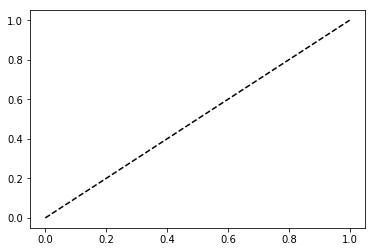

In [50]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_combine2_layers.pdf')
plt.show()


plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
# Zoom in view of the upper left corner.
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_combine2_layers.pdf')
plt.show()


NameError: name 'tpr_lc' is not defined

<Figure size 432x288 with 0 Axes>

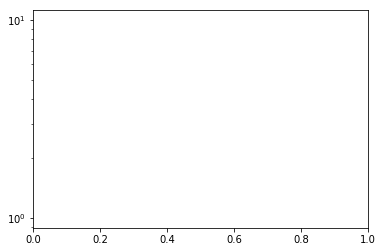

In [51]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.yscale('log')
plt.plot(tpr_lc, 1/fpr_lc, label='LC EMProb')
for layer_i, layer_name in enumerate(layers):
    plt.plot(tpr_flat_nn[layer_i], 1/fpr_flat_nn[layer_i], label='{}'.format(layer_name))
plt.plot(tpr_simpleCombine, 1/fpr_simpleCombine, label='Layers Simple')
plt.plot(tpr_combine, 1/fpr_combine, label='Layers Deep')
plt.legend(loc='best')
plt.xlabel('True Efficiency')
plt.ylabel('Bkgd Rejection')
plt.savefig(plotpath+'roc_reg_combine2_layers.pdf')
plt.show()


In [52]:
#function to split apart a prediction list according to the one hot values.
#really, could have done this by evaluating the nn with a non-concatted nparray, but we already have this handy
def split_pred(onehot, pred):
    list_one = [element_n for element_n, element in enumerate(onehot) if element==1]
    one_vals = [element for element_n, element in enumerate(pred) if element_n in list_one]
    zer_vals = [element for element_n, element in enumerate(pred) if element_n not in list_one]
    
    return one_vals, zer_vals

In [53]:
n_bins = 50
#time for histogramming
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(1-p0['cluster_EM_PROBABILITY'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(1-pp['cluster_EM_PROBABILITY'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('1-Cluster EMProb')
plt.legend()
plt.savefig('Plots/hist_emprob.pdf')
plt.show()

pip_vals_combine, p0_vals_combine = split_pred(y_flat_te_onehot[layer_i][:,1], y_combine_pred[:,1])

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(p0_vals_combine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(pip_vals_combine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('Deep Combined NN')
plt.legend()
plt.savefig('Plots/hist_deep.pdf')
plt.show()

pip_vals_simpleCombine, p0_vals_simpleCombine = split_pred(y_flat_vl_onehot[layer_i][:,1], combined_pred[:,1])
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(p0_vals_simpleCombine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(pip_vals_simpleCombine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('Simple Combined NN')
plt.legend()
plt.savefig('Plots/hist_simple.pdf')
plt.show()

pip_vals_flat = {}
p0_vals_flat = {}
for layer_i, layer_name in enumerate(layers):
    plt.cla(); plt.clf()
    pip_vals_flat[layer_i], p0_vals_flat[layer_i] = split_pred(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1])
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist(p0_vals_flat[layer_i], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
    plt.hist(pip_vals_flat[layer_i], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
    plt.xlabel('{} Flat NN'.format(layer_name))
    plt.legend()
    plt.savefig('Plots/hist_flatnn_{}.pdf'.format(layer_name))
    plt.show()

KeyError: 'cluster_EM_PROBABILITY is not a file in the archive'

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

## 2. Convolutional Neural Network

In [54]:
def format_cnn(data_0, data_1, selected_layer, len_phi = len_phi, len_eta = len_eta):
    layer = layers[selected_layer]
    num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])
    X = np.append(data_0[layer], data_1[layer], axis=0)
    X = X.reshape(X.shape[0], 1, len_phi[selected_layer], len_eta[selected_layer])
    
    Y = np.append(data_0['label'], data_1['label'], axis=0)
    return X, Y, num_pixels

In [56]:

#old, one by one method
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# mswiatlo-- let's do this with the pi+/pi0 samples!

# include the EMB2 layer as a 2D image
selected_layer = 1
layer = layers[selected_layer]
num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])

# X = np.append(elec[layer], pion[layer], axis=0)
X = np.append(pp[layer], p0[layer], axis=0)
# reshape to be [samples][width][height][pixels]
#X = X.reshape(X.shape[0], 1, 128, 4)
X = X.reshape(X.shape[0], 1, 16, 16)

# y = np.append(elec['label'], pion['label'], axis=0)
y = np.append(pp['label'], p0['label'], axis=0)

# split up into training and test datasets
test_size = 4000
validation_size = 1000
from sklearn.model_selection import train_test_split
X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

print (X_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from tensorflow.keras import utils
y_tr_onehot = utils.to_categorical(y_tr, 2)
y_te_onehot = utils.to_categorical(y_te, 2)
y_vl_onehot = utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

(563720, 1, 16, 16)
(563720, 1)
y_train.shape:  (563720, 1)
y_train_onehot.shape:  (563720, 2)


In [57]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras import backend as K
# K.image_data_format('th')
K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

x_cnn = {}
y_cnn = {}
num_pixels_cnn = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn[layer_i], y_cnn[layer_i], num_pixels_cnn[layer_i] = format_cnn(p0, pp, layer_i)

In [58]:
# split up into training and test datasets, using functions
test_size = 24000
validation_size = 24000

x_cnn_tr = {}
x_cnn_te = {}
x_cnn_vl = {}
y_cnn_tr_onehot = {}
y_cnn_te_onehot = {}
y_cnn_vl_onehot = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn_tr[layer_i], x_cnn_te[layer_i], x_cnn_vl[layer_i], y_cnn_tr_onehot[layer_i], y_cnn_te_onehot[layer_i], y_cnn_vl_onehot[layer_i] = make_split_samples(x_cnn[layer_i], y_cnn[layer_i], test_size, validation_size)


y_train.shape:  (520720, 1)
y_train_onehot.shape:  (520720, 2)
y_train.shape:  (520720, 1)
y_train_onehot.shape:  (520720, 2)
y_train.shape:  (520720, 1)
y_train_onehot.shape:  (520720, 2)
y_train.shape:  (520720, 1)
y_train_onehot.shape:  (520720, 2)
y_train.shape:  (520720, 1)
y_train_onehot.shape:  (520720, 2)
y_train.shape:  (520720, 1)
y_train_onehot.shape:  (520720, 2)


In [59]:
# define a simple convolutional model
def baseline_ccn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [62]:
# define a simple convolutional model

filters = [(2,4), (4,4), (4,4), (2,2), (2,2), (2,1)]

def baseline_cnn_model_layers(layer_i):
    # create model
    # with strategy.scope():
    model = Sequential()
    model.add(Conv2D(32, filters[layer_i], input_shape=(1,len_phi[layer_i],len_eta[layer_i]), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [63]:
model_cnn_base_layers = {}
for layer_i, layer_name in enumerate(layers):
    print(layer_name)
    print(len_phi[layer_i])
    print(len_eta[layer_i])
    model_cnn_base_layers[layer_i] = baseline_cnn_model_layers(layer_i)
    model_cnn_base_layers[layer_i].summary()

EMB1
4
128
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 3, 125)        288       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 1, 62)         0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 32, 1, 62)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1984)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 128)               254080    
_________________________________________________________________
dense_55 (Dense)             (None, 2)                 258       
Total params: 254,626
Trainable params: 254,626
Non-trainable params: 0
____________________________________

In [64]:
# define a deep-ish convolutional model
def larger_cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [65]:
# build the model
model_cnn_large = larger_cnn_model()
model_cnn_large.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 13, 13)        544       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 6, 6)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 5, 5)          2064      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 2, 2)          0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 16, 2, 2)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 128)             

In [66]:
history_cnn_base_layers = {}
for layer_i, layer_name in enumerate(layers):
    print('On layer {}'.format(layer_name))
    history_cnn_base_layers[layer_i] = model_cnn_base_layers[layer_i].fit(x_cnn_tr[layer_i], y_cnn_tr_onehot[layer_i], validation_data=(x_cnn_vl[layer_i], y_cnn_vl_onehot[layer_i]), epochs=100, batch_size=200, verbose=2)


On layer EMB1
Epoch 1/100


InvalidArgumentError:  Default MaxPoolingOp only supports NHWC on device type CPU
	 [[node sequential_14/max_pooling2d/MaxPool (defined at <ipython-input-66-60f33b4b73b1>:4) ]] [Op:__inference_train_function_8993841]

Function call stack:
train_function


In [67]:
for layer_i, layer_name in enumerate(layers):
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_cnn_base_layers[layer_i].history['acc'])
    plt.plot(history_cnn_base_layers[layer_i].history['val_acc'])
    plt.title('model accuracy for {}'.format(layer_name))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/accuracy_cnn_{}.pdf'.format(layer_name))
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_cnn_base_layers[layer_i].history['loss'])
    plt.plot(history_cnn_base_layers[layer_i].history['val_loss'])
    plt.title('model loss for {}'.format(layer_name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/loss_cnn_{}.pdf'.format(layer_name))
    plt.show()

KeyError: 0

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [68]:
# fit (train) the larger cnn model
history_cnn_large = model_cnn_large.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=40, batch_size=200, verbose=2)

# final evaluation of the model
scores_cnn_large = model_cnn_large.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores_cnn_large[1]*100))

Epoch 1/40


InvalidArgumentError:  Default MaxPoolingOp only supports NHWC on device type CPU
	 [[node sequential_20/max_pooling2d_6/MaxPool (defined at <ipython-input-68-9c073c96b04b>:2) ]] [Op:__inference_train_function_8994607]

Function call stack:
train_function


In [69]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history_cnn_large.history.keys())
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history_cnn_large.history['acc'])
plt.plot(history_cnn_large.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_cnn_large.history['loss'])
plt.plot(history_cnn_large.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history_cnn_large' is not defined

In [70]:
y_baseline_pred = model_cnn_base.predict(X_te)
fpr_baseline, tpr_baseline, thres_baseline = roc_curve(y_te_onehot[:,1], y_baseline_pred[:,1])
auc_baseline = auc(fpr_baseline, tpr_baseline)
print("Area under curve: {}".format(auc_baseline))

y_large_pred = model_cnn_large.predict(X_te)
fpr_large, tpr_large, thres_large = roc_curve(y_te_onehot[:,1], y_large_pred[:,1])
auc_large = auc(fpr_large, tpr_large)
print("Area under curve: {}".format(auc_large))

NameError: name 'model_cnn_base' is not defined

In [71]:
y_baseline_layers_pred = {}
fpr_baseline_layers = {}
tpr_baseline_layers = {}
thres_baseline_layers = {}
auc_baseline_layers = {}
for layer_i, layer_name in enumerate(layers):
    y_baseline_layers_pred[layer_i] = model_cnn_base_layers[layer_i].predict(x_cnn_te[layer_i])
    fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], thres_baseline_layers[layer_i] = roc_curve(y_cnn_te_onehot[layer_i][:,1], y_baseline_layers_pred[layer_i][:,1])
    auc_baseline_layers[layer_i] = auc(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i])
    print("Area under curve: {}".format(auc_baseline_layers[layer_i]))
#     y_flat_pred[layer_i] = models_flat[layer_i].predict(x_flat_te[layer_i])
#     fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], thres_flat_nn[layer_i] = roc_curve(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1])
#     auc_flat_nn[layer_i] = auc(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i])
#     print("Area under curve: {}".format(auc_flat_nn[layer_i]))


InvalidArgumentError:  Default MaxPoolingOp only supports NHWC on device type CPU
	 [[node sequential_14/max_pooling2d/MaxPool (defined at <ipython-input-71-fa33708889b4>:7) ]] [Op:__inference_predict_function_8994687]

Function call stack:
predict_function


In [72]:
for layer_i, layer_name in enumerate(layers):
    print('Saving {}'.format(layer_name))
    model_cnn_base_layers[layer_i].save(modelpath+"model_{}_cnn_base.h5".format(layer_name))

Saving EMB1
Saving EMB2
Saving EMB3
Saving TileBar0
Saving TileBar1
Saving TileBar2


NameError: name 'fpr_lc' is not defined

<Figure size 432x288 with 0 Axes>

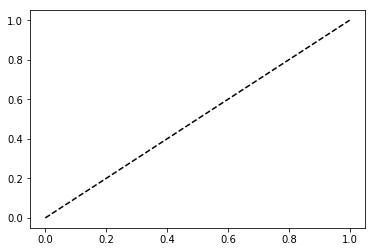

In [73]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.plot(fpr_baseline, tpr_baseline, label='{} (area = {:.3f})'.format("EMB2 CNN Baseline", auc_baseline))
plt.plot(fpr_large, tpr_large, label='{} (area = {:.3f})'.format("EMB2 CNN Large", auc_large))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_combine2_cnn.pdf')
plt.show()


plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
# Zoom in view of the upper left corner.
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.plot(fpr_baseline, tpr_baseline, label='{} (area = {:.3f})'.format("EMB2 CNN Baseline", auc_baseline))
plt.plot(fpr_large, tpr_large, label='{} (area = {:.3f})'.format("EMB2 CNN Large", auc_large))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_combine2_cnn.pdf')
plt.show()

NameError: name 'fpr_lc' is not defined

<Figure size 432x288 with 0 Axes>

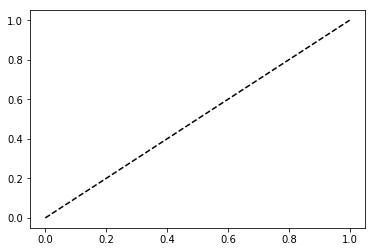

In [74]:
for layer_i, layer_name in enumerate(layers):
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
    plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
    plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} Flat (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
    plt.plot(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], label='{} CNN (area = {:.3f})'.format(layer_name, auc_baseline_layers[layer_i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
    plt.legend(loc='best')
    plt.savefig('Plots/roc_layers_cnn_{}.pdf'.format(layer_name))
    plt.show()


    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    # Zoom in view of the upper left corner.
    plt.xlim(0, 0.25)
    plt.ylim(0.6, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
    plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
    plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} Flat (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
    plt.plot(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], label='{} CNN (area = {:.3f})'.format(layer_name, auc_baseline_layers[layer_i]))
    # ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.savefig('Plots/roc_zoom_layers_cnn_{}.pdf'.format(layer_name))
    plt.show()

## 3. Train multiple ConvNets on the images and merge

Next, try to train convolutional nets on multiple input layers, then merge and flatten the layers.

In [76]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# Mswiatlo-- let's do it on pi+ vs pi0

# This will allow it to be images, instead of flatenned, in emb1
# X0 = np.append(pp['EMB1'], p0['EMB1'], axis=0)

# flatten first layer (for now...) 
X0 = np.append(pp['EMB1'].reshape((len(pp['EMB1']),512)),
              p0['EMB1'].reshape((len(p0['EMB1']),512)), axis=0)

X1 = np.append(pp['EMB2'], p0['EMB2'], axis=0)
X2 = np.append(pp['EMB3'], p0['EMB3'], axis=0)

# reshape to be [samples][width][height][pixels]
# X0 = X0.reshape(X0.shape[0], 1, 128, 4) #uncomment for images mode
X1 = X1.reshape(X1.shape[0], 1, 16, 16)
X2 = X2.reshape(X2.shape[0], 1, 8, 16)

y = np.append(pp['label'], p0['label'], axis=0)

print (X0.shape)
print (X1.shape)
print (X2.shape)
print (y.shape)

# split up into training and test datasets
# test_size = 4000
# validation_size = 1000
test_size = 8000 # double this, mswiatlo
validation_size = 2000 #double this, mswiatlo
from sklearn.model_selection import train_test_split
X0_tr, X0_te_vl, X1_tr, X1_te_vl, X2_tr, X2_te_vl, y_tr, y_te_vl, = train_test_split(X0, X1, X2, y, test_size=test_size+validation_size, random_state=1)
X0_te, X0_vl, X1_te, X1_vl, X2_te, X2_vl, y_te, y_vl, = train_test_split(X0_te_vl, X1_te_vl, X2_te_vl, y_te_vl, test_size=validation_size, random_state=1)

# normalize inputs from 0-255 to 0-1
X0_tr = X0_tr / 255
X0_te = X0_te / 255
X0_vl = X0_vl / 255
X1_tr = X1_tr / 255
X1_te = X1_te / 255
X1_vl = X1_vl / 255
X2_tr = X2_tr / 255
X2_te = X2_te / 255
X2_vl = X2_vl / 255

print (X0_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

(568720, 512)
(568720, 1, 16, 16)
(568720, 1, 8, 16)
(568720, 1)
(558720, 512)
(558720, 1)
y_train.shape:  (558720, 1)
y_train_onehot.shape:  (558720, 2)


In [77]:
# define convolutional model for multiple input images

from keras.models import Model
from keras.layers import concatenate
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [78]:
# create model

def merged_model_emb12():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)

    # concatenate outputs from the two networks above
    x = concatenate([x1, x2]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [79]:
# build the model
model_merged_emb12 = merged_model_emb12()
model_merged_emb12.summary()

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [80]:
# fit (train) the merged model
history = model_merged_emb12.fit([X0_tr, X1_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores = model_merged_emb12.evaluate([X0_te, X1_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

NameError: name 'model_merged_emb12' is not defined

In [81]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history.history.keys())

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('merged_cnn_accuracy.pdf')

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
#plt.savefig('merged_cnn_loss.pdf')

NameError: name 'history' is not defined

In [82]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb12.predict([X0_te, X1_te])
fpr_merge_emb12, tpr_merge_emb12, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge = auc(fpr_merge_emb12, tpr_merge_emb12)
print("Area under curve: {}".format(auc_merge))

NameError: name 'model_merged_emb12' is not defined

NameError: name 'fpr_nn' is not defined

<Figure size 432x288 with 0 Axes>

/collab/usr/gapps/python/build/spack-toss3.3/opt/spack/linux-rhel7-x86_64/gcc-4.9.3/python-3.7.2-asydydmavj2puklmx5t6cu3ruzmg2b3a/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


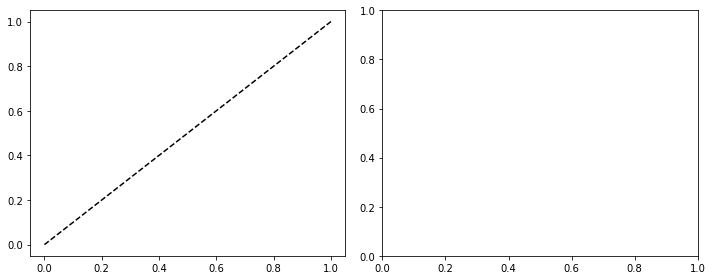

In [83]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')

Next: Include all input images (calorimeter layers)

Visualize the filters: 
 https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59

In [84]:
# create model

def merged_model_emb123():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    
    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu')(input3)
    x3 = MaxPooling2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [85]:
model_merged_emb123 = merged_model_emb123()
model_merged_emb123.summary()

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [86]:
# fit (train) the merged model
history_emb123 = model_merged_emb123.fit([X0_tr, X1_tr, X2_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl, X2_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores_emb123 = model_merged_emb123.evaluate([X0_te, X1_te, X2_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

NameError: name 'model_merged_emb123' is not defined

In [87]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb123.predict([X0_te, X1_te, X2_te])
fpr_merge_emb123, tpr_merge_emb123, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge_emb123 = auc(fpr_merge_emb123, tpr_merge_emb123)
print("Area under curve: {}".format(auc_merge_emb123))

NameError: name 'model_merged_emb123' is not defined

NameError: name 'fpr_nn' is not defined

<Figure size 432x288 with 0 Axes>

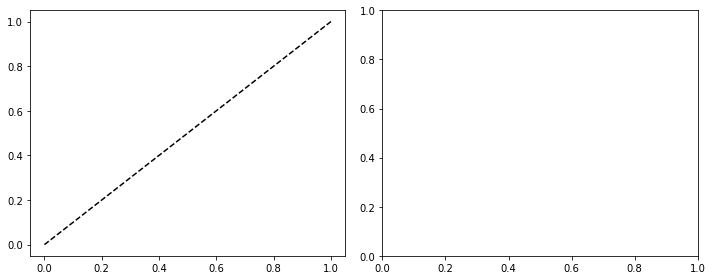

In [88]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')